In my [last post](/2019/05/trading-with-reinforcement-learning-in-python-part-i-gradient-ascent/) we learned what gradient ascent is, and how we can use it to maximize a reward function. This time, instead of using mean squared error as our reward function, we will use the Sharpe Ratio. We can use reinforcement learning to maximize the Sharpe ratio over a set of training data, and attempt to create a strategy with a high Sharpe ratio when tested on out-of-sample data.

## Sharpe Ratio

The Sharpe ratio is a commonly used indicator to measure the risk adjusted performance of an investment over time. Assuming a risk-free rate of 0, the formula for computing Sharpe ratio is simply the mean returns of the investment divided by the standard deviation of the returns. This can be written as:

$$S _T = {A \over \sqrt{B - A^2}}$$

where $A={1\over T}\sum\limits _{t=1}^{T}R _t$, and $B={1\over T}\sum\limits _{t=1}^{T}R _t^2$

This can be coded in Python like so:

In [1]:
def sharpe_ratio(rets):
    return rets.mean() / rets.std()

## Trader Function

We know that we will use the Sharpe ratio as our reward function, but how will we know when to trade? We will use the following function to determine our position, $F$, at time $t$:

$$F _t = \tanh(\theta^T x _t)$$

This function will generate a value between 0 and 1, which will tell us what percentage of the portfolio should buy the asset. $\theta$, like in the last post, will be the parameters we will optimize using gradient ascent, and $x_t$ will be the input vector at time $t$. For this post, we will assign the input vector as $x_t = [1, r_{t - M}, ... , r_t, F_{t - 1}] $, where $r_t$ is the percent change between the asset at time $t$ and $t - 1$, and $M$ is the number of time series inputs. This means that at every time step, the model will be fed its last position and a series of historical price changes that it can use to calculate its next position. We can calculate all of the positions given price series `x`, and `theta` with the following Python function:

In [2]:
import numpy as np

def positions(x, theta):
    M = len(theta) - 2
    T = len(x)
    Ft = np.zeros(T)
    for t in range(M, T):
        xt = np.concatenate([[1], x[t - M:t], [Ft[t - 1]]])
        Ft[t] = np.tanh(np.dot(theta, xt))
    return Ft

## Calculating Returns

Now that we know what our position will be at each time step, we can calculate our returns $R$ at each time step using the following formula:

$$R _t = F _{t-1}r _t - \delta | F _t - F _{t - 1}| $$

In this case $\delta$ is our transaction cost rate. We can code this as a function in Python like so:

In [3]:
def returns(Ft, x, delta):
    T = len(x)
    rets = Ft[0:T - 1] * x[1:T] - delta * np.abs(Ft[1:T] - Ft[0:T - 1])
    return np.concatenate([[0], rets])

These returns can then be used to calculate our Sharpe ratio.

# Gradient Ascent

## Determining the Gradient

In order to perform gradient ascent, we must compute the derivative of the Sharpe ratio with respect to theta, or ${dS _T}\over{d\theta}$ Using the chain rule and the above formulas we can write it as:

$${{dS _T}\over{d\theta}} = \sum\limits_{t=1}^{T} ( {{dS _T}\over{dA}}{{dA}\over{dR _t}} + {{dS _T}\over{dB}}{{dB}\over{dR _t}}) \cdot ({{dR _t}\over{dF _t}}{{dF}\over{d\theta}} + {{dR _t}\over{dF _{t-1}}}{{dF _{t-1}}\over{d\theta}})$$

*For all of the steps to compute the above derivative as well as the partial derivatives, see Gabriel Molina's paper, [Stock Trading with Recurrent Reinforcement Learning (RRL)](http://cs229.stanford.edu/proj2006/Molina-StockTradingWithRecurrentReinforcementLearning.pdf).*

We can compute this derivative in our `gradient` function:

In [4]:
def gradient(x, theta, delta):
    Ft = positions(x, theta)
    rets = returns(Ft, x, delta)
    T = len(x)
    M = len(theta) - 2
    
    A = np.mean(rets)
    B = np.mean(np.square(rets))
    S = A / np.sqrt(B - A ** 2)

    grad = np.zeros(M + 2)  # initialize gradient
    dFpdtheta = np.zeros(M + 2)  # for storing previous dFdtheta
    
    for t in range(M, T):
        xt = np.concatenate([[1], x[t - M:t], [Ft[t-1]]])
        dRdF = -delta * np.sign(Ft[t] - Ft[t-1])
        dRdFp = x[t] + delta * np.sign(Ft[t] - Ft[t-1])
        dFdtheta = (1 - Ft[t] ** 2) * (xt + theta[-1] * dFpdtheta)
        dSdtheta = (dRdF * dFdtheta + dRdFp * dFpdtheta)
        grad = grad + dSdtheta
        dFpdtheta = dFdtheta

        
    return grad, S

## Training

Now that we have our gradient function, we can optimize our parameters using gradient ascent. Like the last post, we will update our $\theta$ each epoch using $\theta = \theta + \alpha{dS _T \over d\theta}$, where $\alpha$ is our learning rate.

In [5]:
def train(x, epochs=500, M=5, commission=0.0025, learning_rate = 0.1):
    theta = np.ones(M + 2)
    sharpes = np.zeros(epochs) # store sharpes over time
    for i in range(epochs):
        grad, sharpe = gradient(x, theta, commission)
        theta = theta + grad * learning_rate

        sharpes[i] = sharpe
    
    
    print("finished training")
    return theta, sharpes

# Trading with Bitcoin

Now that we have our model, let's test it using historical bitcoin data. I will be using a history of all bitcoin transactions on the Bitstamp exchange, downloaded from [bitcoincharts.com](https://api.bitcoincharts.com/v1/csv/). Let's load it in:

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12, 9) # (w, h)
import pandas as pd

btc = pd.read_csv("bitstampUSD.csv", names=["utc", "price", "volume"]).set_index('utc')
btc.index = pd.to_datetime(btc.index, unit='s')

# RESAMPLED TO HOURLY

In [32]:
prices = btc.resample('10min', label="right").mean()['price']
rets = prices.diff()[1:]
rets = rets[~rets.isna()]

For this strategy we will train the model on 1000 samples, and then trade on the next 200 samples. Let's normalize the data, and then split it into training and test data.

In [33]:
x = np.array(rets)
x = (x - np.mean(x)) / np.std(x) # normalize

N = 1000
P = 200
x_train = x[-(N+P):-P]
x_test = x[-P:]

Now we're ready to train! We'll give the model a look-back window of 5.

In [34]:
theta, sharpes = train(x_train, epochs=500, M=5, commission=0.0025, learning_rate=.001)

finished training


In order to see how well the training did, we can graph the resulting Sharpe ratio over each epoch, and hopefully see it converge to a maximum.

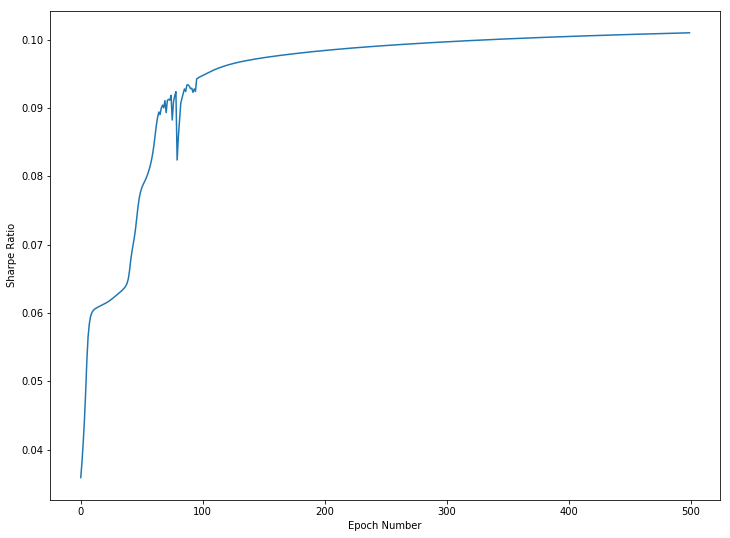

In [35]:
plt.plot(sharpes)
plt.xlabel('Epoch Number')
plt.ylabel('Sharpe Ratio');

We can see that as the model trains, it converges towards a maximum Sharpe Ratio. Lets see how the model performed over the training data:

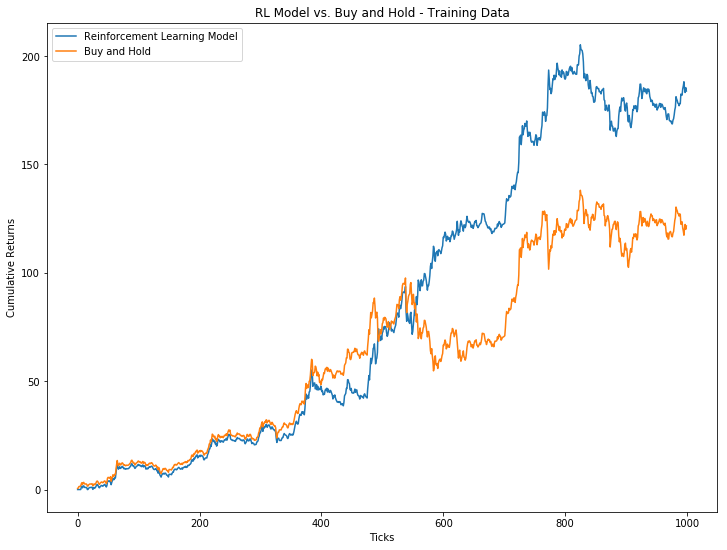

In [36]:
train_returns = returns(positions(x_train, theta), x_train, 0.0025)
plt.plot((train_returns).cumsum(), label="Reinforcement Learning Model")
plt.plot(x_train.cumsum(), label="Buy and Hold")
plt.xlabel('Ticks')
plt.ylabel('Cumulative Returns');
plt.legend()
plt.title("RL Model vs. Buy and Hold - Training Data");

We can see that, over the training data, our reinforcement learning model greatly outperformed simply buying and holding the asset. Lets see how it does over the next 200 ticks, which have been held out from the model.

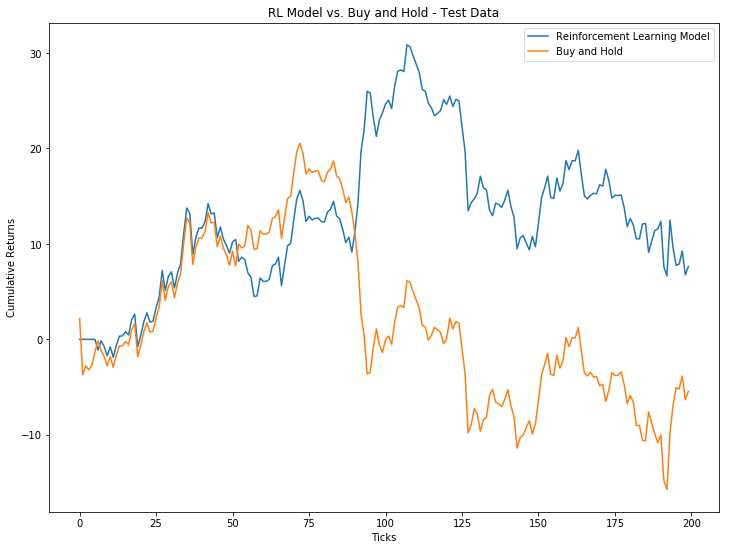

In [37]:
test_returns = returns(positions(x_test, theta), x_test, 0.0025)
plt.plot((test_returns).cumsum(), label="Reinforcement Learning Model")
plt.plot(x_test.cumsum(), label="Buy and Hold")
plt.xlabel('Ticks')
plt.ylabel('Cumulative Returns');
plt.legend()
plt.title("RL Model vs. Buy and Hold - Test Data");

Once again the model outperforms the asset! This model may be able to be improved by engineering more features (inputs), but it is a great start. For more reading on reinforcement learning in stock trading, be sure to check out these papers:

* [Reinforcement Learning for Trading](http://papers.nips.cc/paper/1551-reinforcement-learning-for-trading.pdf)
* [Stock Trading with Recurrent Reinforcement Learning](http://cs229.stanford.edu/proj2006/Molina-StockTradingWithRecurrentReinforcementLearning.pdf)